In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 24260.66it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [11]:
from ai2thor.controller import Controller
import numpy as np

rand_idx = np.random.randint(0, 10000, (1,))[0]
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30, renderDepthImage=True)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

In [9]:
controller.stop()

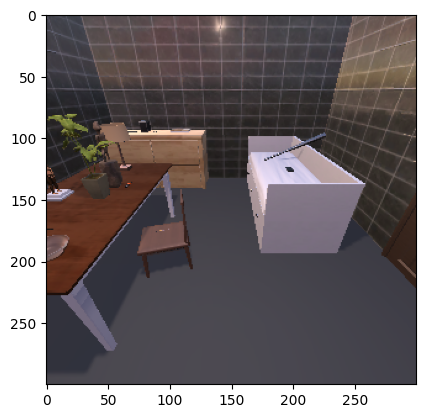

In [3]:
import matplotlib.pyplot as plt
event = controller.step("MoveAhead")
plt.imshow(event.frame)

In [4]:
event.metadata["agent"]["position"]

{'x': 2.25, 'y': 0.9009997844696045, 'z': 1.75}

In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnvNoPenalty, CLIPNovelty, ClipEnvNoPenalty, load_actor_critic
from models import FrozenResNetEncoder, ConvDepthEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [6]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
depth_encoder = ConvDepthEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnvNoPenalty(clip_novelty)
clip_actor_critic = ActorCritic(encoder, depth_encoder, actor, critic)


In [7]:
from torchinfo import summary

summary(clip_actor_critic.actor), summary(clip_actor_critic.critic), summary(clip_actor_critic.rgb_encoder), summary(clip_actor_critic.depth_encoder)

(==========================================================================================
 Layer (type:depth-idx)                                            Param #
 SlidingWindowTransformerActor                                     4,096
 ├─Embedding: 1-1                                                  384
 ├─Linear: 1-2                                                     32,896
 ├─TransformerEncoder: 1-3                                         --
 │    └─ModuleList: 2-1                                            --
 │    │    └─TransformerEncoderLayer: 3-1                          198,272
 │    │    └─TransformerEncoderLayer: 3-2                          198,272
 │    │    └─TransformerEncoderLayer: 3-3                          198,272
 │    │    └─TransformerEncoderLayer: 3-4                          198,272
 ├─Linear: 1-4                                                     387
 Total params: 830,851
 Trainable params: 830,851
 Non-trainable params: 0
 ============================

In [7]:
load_actor_critic(clip_actor_critic, "data/weight_long.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/weight_long.pt


In [1]:
from rl import PPO, inference, inference_video_mp4, teleport
import torch

def get_distributions(ppo: PPO, obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    return dist


point = teleport(controller).metadata["agent"]["position"]
print(point)
inference(get_distributions, controller, ppo=PPO(0.08), init_position=point, env=clip_env, actor_critic=clip_actor_critic)

NameError: name 'controller' is not defined

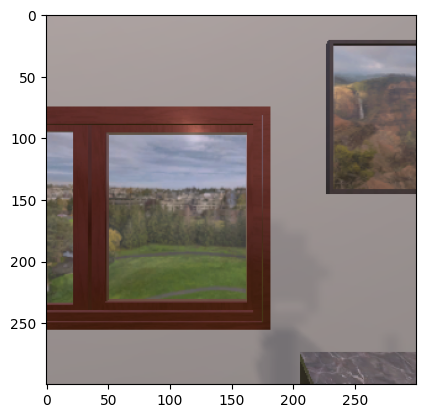

In [258]:
# teleport(controller, trapped)
event = controller.step("MoveAhead")
plt.imshow(event.frame)

In [259]:
event.metadata["agent"]["position"]

{'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654}

In [11]:
controller.stop()